In [1]:
import os
import cv2


from helpers.DatasetProcess import dataset_to_df, search_df
from helpers.PlotExtension import norm_to_plot, plot_img_grid,img_plot
from helpers.WaveletPacketV3 import wpt_dec, plot_wpt_nodes, plot_wpt_fun

import ptwt


import numpy as np
import pandas as pd

from tqdm import tqdm

import matplotlib.pyplot as plt
# import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import ImageGrid


import torch
from torch import nn, einsum
import torch.nn.functional as F


# The cross-entropy loss penalizes the model more when it is more confident in the incorrect class
from torch.nn import CrossEntropyLoss

# Adam is an optimization algorithm that can be used instead of the classical SGD procedure
# to update network weights iterative based in training data.
from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader, random_split

from torchvision import transforms
from torchvision.transforms import v2
from torchvision.io import read_image

from torchinfo import summary

from einops import rearrange, repeat
from einops.layers.torch import Rearrange


In [2]:
print(f"torch version: {torch.__version__}")
print(f"GPU Card: {torch.cuda.get_device_name(0)}")
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Torch is using device:', device)
torch.cuda.get_device_name(device)

NUM_WORKERS = os.cpu_count()
print("CPU Count:", NUM_WORKERS)

torch version: 2.2.1+cu121
GPU Card: NVIDIA GeForce RTX 3070 Ti Laptop GPU
Torch is using device: cuda:0
CPU Count: 20


In [3]:
path = '../../../data/real-vs-fake'
relative_paths = ["/train/real", "/train/fake", "/test/real", "/test/fake", "/valid/real", "/valid/fake"]
paths_classes = ["REAL", "FAKE", "REAL", "FAKE", "REAL", "FAKE"]

In [4]:
try:
    df_all = pd.read_csv(f'{path}/df_all.csv')
    df_train = pd.read_csv(f'{path}/df_train.csv')
    df_val = pd.read_csv(f'{path}/df_val.csv')
    df_test = pd.read_csv(f'{path}/df_test.csv')
    classes_stats = pd.read_csv(f'{path}/classes_stats.csv')
except FileNotFoundError:
    df_all, df_train, df_val, df_test, classes_stats = dataset_to_df(
        path, relative_paths, paths_classes, 0.8, 0.14, 0.06)
    df_all.to_csv(f'{path}/df_all.csv', index=False)
    df_train.to_csv(f'{path}/df_train.csv', index=False)
    df_val.to_csv(f'{path}/df_val.csv', index=False)
    df_test.to_csv(f'{path}/df_test.csv', index=False)
    classes_stats.to_csv(f'{path}/classes_stats.csv')

classes_stats

,Unnamed: 0,REAL,FAKE,Total
0,Training,56000,56000,112000
1,Validation,9800,9800,19600
2,Testing,4200,4200,8400
3,Row_Total,70000,70000,140000


In [5]:
df_all.iloc[[0,-1]]

,Image_path,Height,Width,Channels,Class,Class_Codes,Class_Onehot
0,../../../data/real-vs-fake//train/real/00000.jpg,256,256,RGB,REAL,1,[1 0]
139999,../../../data/real-vs-fake//valid/fake/ZZSKUAF...,256,256,RGB,FAKE,0,[0 1]


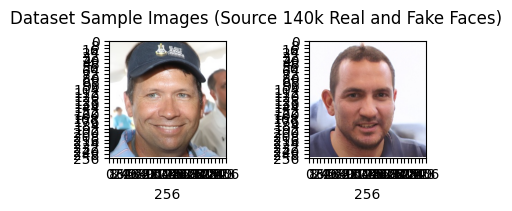

In [6]:
r_img_idx, f_img_idx = 6, -3
step=8


fig, axs = plt.subplots(1, 2, layout="constrained", figsize=(4, 2))
fig.suptitle('Dataset Sample Images (Source 140k Real and Fake Faces)')

r_img=plt.imread(df_all.iloc[r_img_idx, 0])
f_img=plt.imread(df_all.iloc[f_img_idx, 0])

axs[0].imshow(r_img)
axs[0].set(xlabel=df_all.iloc[r_img_idx, 2])
axs[0].set(xticks=np.arange(0, r_img.shape[1]+1, step=step), yticks=np.arange(0, r_img.shape[0]+1, step=step))

axs[1].imshow(f_img)
axs[1].set(xlabel=df_all.iloc[f_img_idx, 2])
axs[1].set(xticks=np.arange(0, f_img.shape[1]+1, step=step), yticks=np.arange(0, f_img.shape[0]+1, step=step))

plt.show()

In [7]:
training_phase = 1

In [8]:
model_type = "vit"
add_extra_epochs = True  # if True then continue for extra epochs from the starting epoch

# If True load a pretrained model, and start_epoch = epoch of the model . Else if False then start_epoch = 0
start_from_model = False

In [9]:
model_state_path = f"../../../weights/{model_type}_wpt_rvfs/checkpoint/"

# model_file_name = f"vit_wpt_rvfs_ph1_lastEpoch199_acc62.91"  # file name of the saved model

# checkpoint = torch.load(model_state_path+model_file_name)

In [10]:
if start_from_model:
    training_phase_lst = checkpoint['training_phase_lst']
    training_phase = training_phase_lst[-1]+1

print(training_phase)

1


In [11]:
# Wavelet Packet Transform Hyper Parameters
wpt_fun = 'haar'
wpt_level = 2
features = ((2**wpt_level)**2) # 16 for level 2
channels = len(df_all.iloc[0, 3])
print(channels)

3


In [12]:
img_trans_norm_mean = [0.4913997551666284, 0.48215855929893703, 0.4465309133731618]
img_trans_norm_std = [0.24703225141799082, 0.24348516474564, 0.26158783926049628]

In [13]:
in_img_size = int(df_all.iloc[0, 1])
img_size = int(in_img_size/(2**wpt_level))  # Input image height/width in pixels
# The height/width of a patch in pixels (patch is a slice of an image)
patch_size = 4

image_patch_flat_size = (channels) * patch_size**2  # 16 Channels x Patch_height**2
embed_size = image_patch_flat_size
# embed_size = features * image_patch_flat_size
mlp_dim = 384  # dim of the last mlp classifier

train_batch_size = 100  # https://www.youtube.com/watch?v=Owm1H0ukjS4
valid_batch_size = 100

num_classes = 2
encoder_depth = 2
attention_heads = 16

print(f'Flattened dimension size(of a patch): {image_patch_flat_size}')
print(f'Embedding Size: {embed_size}')
print(f'Output MLP size: {mlp_dim}')

Flattened dimension size(of a patch): 48
Embedding Size: 48
Output MLP size: 384


In [14]:
n_extra_epochs = 10
max_epochs = 200

start_epoch = checkpoint['epoch'] if start_from_model else 0
end_epoch = start_epoch + n_extra_epochs if add_extra_epochs else max_epochs
delta_epochs = end_epoch-start_epoch

print(f"Train another {delta_epochs} epochs after epoch {start_epoch} ")

Train another 10 epochs after epoch 0 


In [15]:
base_lr = 0.01         # Base Learning rate 0.1 for SGD , 0.0001 for Adam
momentum = 0.9          # Momentum for SGD
weight_decay = 0.001     # Weight decay for Adam


loss_algo = CrossEntropyLoss

optimize_algo = SGD # Adam
optimize_args = {"lr": base_lr,
                #  "weight_decay": weight_decay ,
                #  "momentum": momentum  # comment momentum for Adam
                 }

use_scheduler = False
schedule_algo = CosineAnnealingLR
schedule_args = {"T_max": delta_epochs}

In [16]:
hyper_parameters = {
    "training_phase": training_phase,
    "model_type": model_type,
    "wpt_fun": wpt_fun,
    "wpt_level": wpt_level,
    "channels": channels,
    "img_trans_norm_mean": img_trans_norm_mean,
    "img_trans_norm_std": img_trans_norm_std,
    "in_img_size":in_img_size,
    "img_size": img_size,
    "patch_size": patch_size,
    "image_patch_flat_size": image_patch_flat_size,
    "embed_size": embed_size,
    "mlp_dim": mlp_dim,
    "train_batch_size": train_batch_size,
    "valid_batch_size": valid_batch_size,
    "num_classes": num_classes,
    "encoder_depth": encoder_depth,
    "attention_heads": attention_heads,
    "n_extra_epochs ": n_extra_epochs,
    "base_lr": base_lr,
    "momentum": momentum,
    "weight_decay": weight_decay,
    "loss_algo": loss_algo,
    "optimize_algo": optimize_algo,
    "optimize_args": optimize_args,
    "use_scheduler": use_scheduler,
    "schedule_algo": schedule_algo,
    "schedule_args": schedule_args
}

hyper_parameters

{'training_phase': 1,
 'model_type': 'vit',
 'wpt_fun': 'haar',
 'wpt_level': 2,
 'channels': 3,
 'img_trans_norm_mean': [0.4913997551666284,
  0.48215855929893703,
  0.4465309133731618],
 'img_trans_norm_std': [0.24703225141799082,
  0.24348516474564,
  0.2615878392604963],
 'in_img_size': 256,
 'img_size': 64,
 'patch_size': 4,
 'image_patch_flat_size': 48,
 'embed_size': 48,
 'mlp_dim': 384,
 'train_batch_size': 100,
 'valid_batch_size': 100,
 'num_classes': 2,
 'encoder_depth': 2,
 'attention_heads': 16,
 'n_extra_epochs ': 10,
 'base_lr': 0.01,
 'momentum': 0.9,
 'weight_decay': 0.001,
 'loss_algo': torch.nn.modules.loss.CrossEntropyLoss,
 'optimize_algo': torch.optim.sgd.SGD,
 'optimize_args': {'lr': 0.01},
 'use_scheduler': False,
 'schedule_algo': torch.optim.lr_scheduler.CosineAnnealingLR,
 'schedule_args': {'T_max': 10}}

In [17]:
# https://github.com/lucidrains/vit-pytorch/blob/main/vit_pytorch/vit.py
# replaced the attention mechanism with MHA from Sebastian Raschka

# helpers
def pair(t):
    return t if isinstance(t, tuple) else (t, t)

# classes


class WPT2D(nn.Module):
    def __init__(self, wpt_fun, wpt_level, mode='boundary'):
        super().__init__()
        self.wpt_fun = wpt_fun
        self.wpt_level = wpt_level
        self.mode = mode

    def forward(self, x):

        ptwp = ptwt.WaveletPacket2D(
            x, self.wpt_fun, mode=self.mode, maxlevel=self.wpt_level)
        paths_keys = [key for key in ptwp if len(key) == self.wpt_level]
        nodes = [ptwp[path].unsqueeze(1) for path in paths_keys]
        nodes_tensor = torch.cat(nodes, dim=1)

        return nodes_tensor


class Patch_Embed(nn.Module):
    def __init__(self, patch_height, patch_width, patch_dim, embed_dim):
        super().__init__()
        self.patch_embed = nn.Sequential(
            # This rearrangement is suitable for the wavelet packet features
            # torch.Size([200, 16, 3, 32, 32])
            Rearrange('b f c (h p1) (w p2) -> b (f h w) (c p1 p2)',
                      p1=patch_height, p2=patch_width),
            nn.Linear(patch_dim, embed_dim),
        )

    def forward(self, x):
        return self.patch_embed(x)


class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)


class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout=0.):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.model(x)


# inspired by Sebstian Raschka with modifications
class MHA(nn.Module):
    def __init__(self, embed_dim: int, num_of_head: int = 12, Dropout=0.2) -> None:
        super().__init__()
        self.embed_dim = embed_dim
        self.inner_dim = embed_dim*2
        self.num_of_head = num_of_head
        self.dim_per_head = self.inner_dim // self.num_of_head
        self.Wq = nn.Linear(in_features=embed_dim, out_features=self.inner_dim)
        self.Wk = nn.Linear(in_features=embed_dim, out_features=self.inner_dim)
        self.Wv = nn.Linear(in_features=embed_dim, out_features=self.inner_dim)

        self.dropout = Dropout
        self.linear = nn.Linear(
            in_features=self.inner_dim, out_features=embed_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        q = self.Wq(x)
        k = self.Wk(x)
        v = self.Wv(x)

        Q = rearrange(q, 'b s (h d) -> b h s d',
                      h=self.num_of_head, d=self.dim_per_head)
        K = rearrange(k, 'b s (h d) -> b h s d',
                      h=self.num_of_head, d=self.dim_per_head)
        V = rearrange(v, 'b s (h d) -> b h s d',
                      h=self.num_of_head, d=self.dim_per_head)

        use_dropout = 0.0 if not self.training else self.dropout

        attention = F.scaled_dot_product_attention(
            Q, K, V, dropout_p=use_dropout)

        # Note:
        # dimensions of tensors inside F.scaled_dot_product_attention as follows:
        # Q(b h s d) . KT(b h d s) ==> b h s s
        # weight(b h s s).V(b h s d) ==> attention (b h s d)

        attention = rearrange(attention, 'b h s d -> b s (h d)')
        attention = self.linear(attention)
        return attention


class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout=0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                # PreNorm(dim, Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout)),
                PreNorm(dim, MHA(embed_dim=dim,
                        num_of_head=heads, Dropout=dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout=dropout))
            ]))

    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x


class vit(nn.Module):
    def __init__(self, *, image_size, patch_size, wpt_fun, wpt_level, features, num_classes, dim, depth, heads, mlp_dim, pool='cls', channels=3, dim_head=64, emb_dropout=0., dropout=0.):
        super().__init__()

        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        num_patches = features * (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width

        # num_patches = (image_height // patch_height) * (image_width // patch_width)
        # patch_dim = features * channels * patch_height * patch_width

        assert pool in {
            'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        self.to_wpt2d = WPT2D(wpt_fun, wpt_level, mode='boundary')
        self.to_patch_embedding = Patch_Embed(
            patch_height, patch_width, patch_dim, dim)

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(
            dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, img):
        # print(img.shape)
        img_wpt = self.to_wpt2d(img)
        # print(img_wpt.shape)
        x = self.to_patch_embedding(img_wpt)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b=b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)

        x = self.transformer(x)

        x = x.mean(dim=1) if self.pool == 'mean' else x[:, 0]

        x = self.to_latent(x)
        return self.mlp_head(x)

In [18]:
# Custom Dataset Class
class Images_Dataset(Dataset):
    def __init__(self, annotations_df, transform=None):

        self.annotation = annotations_df
        self.transform = transform

    def __getitem__(self, index):

        img = read_image(self.annotation.iloc[index, 0])
        labels = torch.tensor(
            self.annotation.iloc[index, 5], dtype=torch.int64)

        if self.transform:
            img_t = self.transform(img)
        else:
            img_t = img

        return img_t, labels

    def __len__(self):
        # To return the length of the dataset
        return self.annotation.shape[0]

In [19]:
transform_train = transforms.Compose([
    # Note:
    # We want to introduce augmentation for the dataset using transformations 
    # which doesn't change the real images into fake
    # v2.CenterCrop(size=in_img_size),
    v2.Resize(size=int(in_img_size/2)),
    transforms.ToPILImage(),
    # v2.RandomAffine(degrees=(-90, 90), translate=(0.1, 0.3), scale=(0.75, 1)),
    # transforms.ToTensor(),
    v2.ToImage(), 
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(img_trans_norm_mean, img_trans_norm_std),
])

transform_valid = transforms.Compose([
    # transforms.ToTensor(),
    # v2.CenterCrop(size=in_img_size),
    v2.Resize(size=int(in_img_size/2)),
    v2.ToImage(), 
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(img_trans_norm_mean, img_trans_norm_std),
])

In [20]:
# Define the dataset object and configure the Data Loader

train_set  = Images_Dataset(df_train, transform_train)

train_loader = DataLoader(dataset=train_set,
                          batch_size=train_batch_size,
                          # Drops the last mini batch if less than the batch size (could enhance the model accuracy)
                          drop_last=True,
                          shuffle=True,
                          pin_memory=True,
                          num_workers=NUM_WORKERS)


valid_set  = Images_Dataset(df_val, transform_valid)

valid_loader= DataLoader(dataset=valid_set ,
                          batch_size=valid_batch_size,
                          # Drops the last mini batch if less than the batch size (could enhance the model accuracy)
                          drop_last=True,
                          shuffle=False,
                          pin_memory=True,
                          num_workers=NUM_WORKERS)

In [21]:
print("Total number of training batches:", len(train_loader))
print("Total number of validation batches:", len(valid_loader))

Total number of training batches: 1120
Total number of validation batches: 196


In [22]:
sample_imgt_bch, label_bch = next(iter(train_loader))

In [23]:
print(f"Batch of Images Shape: {sample_imgt_bch.size()}")
print(f"Batch of Labels Shape: {label_bch.size()}")
# print(label_bch)

Batch of Images Shape: torch.Size([100, 3, 128, 128])
Batch of Labels Shape: torch.Size([100])


In [24]:
sample_img_idx = 12

sample_img = sample_imgt_bch[sample_img_idx, :, :, :]

In [25]:
sample_img_a,nodes, *_, wp_fun, wp_name, _, _ = wpt_dec(sample_img, wpt_fun, wpt_level)
sample_img_a.shape

(128, 128, 3)

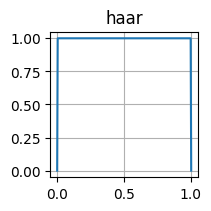

In [26]:
plot_wpt_fun(sample_img, wpt_fun, wpt_level)

Text(0.5, 1.0, 'Label: Fake')

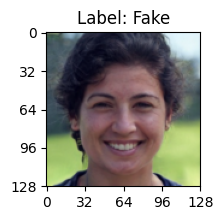

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(2, 2))

ax.imshow(norm_to_plot(sample_img_a)[1])
ax.set(xticks=np.arange(0, sample_img_a.shape[1]+1, step=32),
       yticks=np.arange(0, sample_img_a.shape[0]+1, step=32))
ax.set_title(f'Label: {"Real" if label_bch[sample_img_idx].item()==1 else "Fake"}')

/home/osmahus/pytVenv/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  func(*args, **kwargs)
/home/osmahus/pytVenv/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


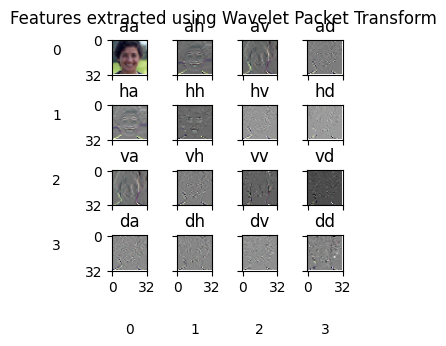

In [28]:
plot_wpt_nodes(sample_img, wpt_fun, wpt_level,setticks1=32,setticks2=32,figsize=(3,3))

Shape of the image patches matrix:  (8, 8, 4, 4, 3)


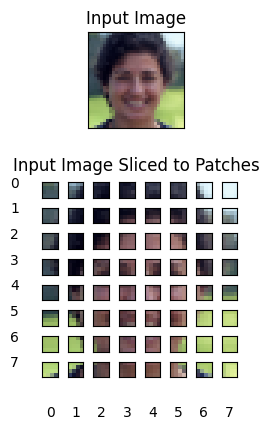

In [29]:
img_plot(plt, nodes[0,:,:,:], patch_size, CHW_Image=False, figsize=(3, 4),axes_pad=0.1)

In [30]:
if model_type == "vit":
    model = vit(
        image_size=img_size,
        patch_size=patch_size,
        features=features,
        wpt_fun=wpt_fun,
        wpt_level=wpt_level,
        num_classes=num_classes,
        dim=embed_size,
        depth=encoder_depth,
        heads=attention_heads,
        mlp_dim=mlp_dim,
        emb_dropout=0.1,
        dropout=0.1,
        channels=channels
    )
else:
    raise ValueError(
        "You must set the model_type variable to any of: vit ,....")

In [31]:
# output = model(sample_nodes_tnsr_bch)

print("Input Shape: ", sample_imgt_bch.size())
# print("Output Shape: ", output.size())

summary(model=model,
        input_size=sample_imgt_bch.size(),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Input Shape:  torch.Size([100, 3, 128, 128])


Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
vit (vit)                                          [100, 3, 128, 128]   [100, 2]             196,704              True
├─WPT2D (to_wpt2d)                                 [100, 3, 128, 128]   [100, 16, 3, 32, 32] --                   --
├─Patch_Embed (to_patch_embedding)                 [100, 16, 3, 32, 32] [100, 1024, 48]      --                   True
│    └─Sequential (patch_embed)                    [100, 16, 3, 32, 32] [100, 1024, 48]      --                   True
│    │    └─Rearrange (0)                          [100, 16, 3, 32, 32] [100, 1024, 48]      --                   --
│    │    └─Linear (1)                             [100, 1024, 48]      [100, 1024, 48]      2,352                True
├─Dropout (dropout)                                [100, 1025, 48]      [100, 1025, 48]      --                   --
├─Transformer (transformer)                      

In [32]:
criterion = loss_algo()
optimizer = optimize_algo(model.parameters(), **optimize_args)
scheduler = schedule_algo(optimizer, **schedule_args)

In [33]:
if start_from_model:
    model.load_state_dict(checkpoint['model'])
    if checkpoint['optimizer_lst'][-1]==optimize_algo:
        optimizer.load_state_dict(checkpoint['optimizer'])
    best_acc = checkpoint['best_acc']
    tr_loss_lst = checkpoint['tr_loss_lst']
    tr_acc_lst = checkpoint['tr_acc_lst']
    val_loss_lst = checkpoint['val_loss_lst']
    val_acc_lst = checkpoint['val_acc_lst']
    optimizer_lst = checkpoint['optimizer_lst']
    running_lr_lst = checkpoint['running_lr_lst']
    training_phase_lst = checkpoint['training_phase_lst']
    hyper_parameters_lst = checkpoint['hyper_parameters_lst']

else:
    best_acc = 0

    tr_loss_lst = []
    tr_acc_lst = []
    val_loss_lst = []
    val_acc_lst = []
    optimizer_lst = []
    running_lr_lst = []
    training_phase_lst=[]
    hyper_parameters_lst = []

In [34]:
model.to(device)
for epoch in range(start_epoch, end_epoch):

    print(f'\n epoch: {epoch+1}/{end_epoch}')

    ##########################################################
    model.train(True)
    tr_loss = 0
    correct = 0
    total = 0
    running_lr = 0

    loop1 = tqdm(enumerate(train_loader), total=len(train_loader))
    for batch_idx, (*_, inputs, targets) in loop1:
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Zero gradients for every batch
        optimizer.zero_grad()
        # Backward path
        loss.backward()

        running_lr += optimizer.param_groups[-1]['lr']

        # Optimizer Step
        optimizer.step()

        tr_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        avg_tr_loss = tr_loss/(batch_idx+1)
        avg_tr_accuracy = 100.*correct/total
        avg_running_lr = running_lr/(batch_idx+1)

        loop1.set_description(f"Train--Epoch [{epoch+1}/{end_epoch}]")
        loop1.set_postfix(loss=avg_tr_loss, acc=avg_tr_accuracy)

    ##########################################################
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():

        loop2 = tqdm(enumerate(valid_loader), total=len(valid_loader))
        for batch_idx, (*_, inputs, targets) in loop2:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            avg_val_loss = val_loss/(batch_idx+1)
            avg_val_accuracy = 100.*correct/total

            loop2.set_description(f"Valid--Epoch [{epoch+1}/{end_epoch}]")
            loop2.set_postfix(loss=avg_val_loss, acc=avg_val_accuracy)
    ##########################################################

    tr_loss_lst.append(avg_tr_loss)
    tr_acc_lst.append(avg_tr_accuracy)
    val_loss_lst.append(avg_val_loss)
    val_acc_lst.append(avg_val_accuracy)
    optimizer_lst.append(type(optimizer).__name__)
    running_lr_lst.append(avg_running_lr)
    training_phase_lst.append(training_phase)
    hyper_parameters_lst.append(hyper_parameters)

    # Save checkpoint.
    if avg_val_accuracy > best_acc:
        best_acc = avg_val_accuracy

        print('Saving..')
        state = {"model": model.state_dict(),
                 "optimizer": optimizer.state_dict(),
                 "epoch": epoch,
                 "best_acc": best_acc,
                 "tr_loss_lst": tr_loss_lst,
                 "tr_acc_lst": tr_acc_lst,
                 "val_loss_lst": val_loss_lst,
                 "val_acc_lst": val_acc_lst,
                 "optimizer_lst": optimizer_lst,
                 "running_lr_lst": running_lr_lst,
                 "training_phase_lst":training_phase_lst,
                 "hyper_parameters_lst": hyper_parameters_lst
                 }
        torch.save(state, model_state_path +
                   f'{model_type}_wpt_rvfs_ph{training_phase}_Epoch{epoch}_acc{best_acc:.2f}')

    ##########################################################

    if use_scheduler:
        scheduler.step()  # step scheduling


 epoch: 1/10


  0%|          | 0/1120 [00:29<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 6.26 GiB. GPU 0 has a total capacity of 8.00 GiB of which 0 bytes is free. Process 465393 has 17179869184.00 GiB memory in use. Including non-PyTorch memory, this process has 17179869184.00 GiB memory in use. Of the allocated memory 15.01 GiB is allocated by PyTorch, and 4.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
state = {"model": model.state_dict(),
            "optimizer": optimizer.state_dict(),
            "epoch": epoch,
            "best_acc": best_acc,
            "tr_loss_lst": tr_loss_lst,
            "tr_acc_lst": tr_acc_lst,
            "val_loss_lst": val_loss_lst,
            "val_acc_lst": val_acc_lst,
            "optimizer_lst": optimizer_lst,
            "running_lr_lst": running_lr_lst,
            "training_phase_lst":training_phase_lst,
            "hyper_parameters_lst": hyper_parameters_lst
            }
torch.save(state, model_state_path +
            f'{model_type}_wpt_rvfs_ph{training_phase}_lastEpoch{epoch}_acc{avg_val_accuracy:.2f}')

In [ ]:
fig, axs = plt.subplots(2, 1)

axs[0].plot(range(len(tr_loss_lst )), tr_loss_lst , label='Train Loss')
axs[0].plot(range(len(val_loss_lst)), val_loss_lst, label='Validation Loss')
axs[0].set_ylim([0,2.5])

axs[1].plot(range(len(tr_acc_lst)), tr_acc_lst, label='Train Accuracy')
axs[1].plot(range(len(val_acc_lst)), val_acc_lst, label='Validation Accuracy')
axs[1].set_ylim([40,80])

axs[0].legend()
axs[1].legend()
plt.show()

In [ ]:
print(f"Best Validation Accuracy is: {best_acc:.2f}%")

In [ ]:
fig, axs = plt.subplots(1, 1)

axs.plot(tr_loss_lst, running_lr_lst, label=f'lr change for the {optimizer_lst[-1]} optimizer')
axs.set_xlabel('Training_Loss')
axs.set_ylabel('Running Learning Rate')
axs.legend()
plt.show()